#Creating Seperate files

1. Added albumentation data augmentation method in data loader file
2. Implemented gradcam in a seperate file 


##Achieved : **87.71%** using Resnet18 model with Albumentation 

Remarks:
Learnings:
1. How to incorporate albumentation in pytorch dataloader
2. Gradcam implementation and working

After 14 epochs model started to saturate and lead to overfitting. This can be avois=ded further by using regularizations and different image augmentation techniques

In [1]:
! pip install albumentations==0.4.6

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Mounted at /content/drive


In [3]:
import sys
import os
sys.path.append('/content/gdrive/')
py_file_location = "/content/drive/My Drive/S9_CIFAR10_Albumentation/"
sys.path.append(os.path.abspath(py_file_location))

In [4]:
%cd '/content/drive/My Drive/S9_CIFAR10_Albumentation'
!pwd
!ls

/content/drive/My Drive/S9_CIFAR10_Albumentation
/content/drive/My Drive/S9_CIFAR10_Albumentation
data	     s9_cifar_dataloader.py  s9_gradcam.py    s9_train_file.py
__pycache__  s9_cifar_modelfile.py   s9_test_file.py


In [5]:
# Import your module or file
from s9_cifar_modelfile import Net, ResNet18
from s9_cifar_dataloader import AlbumentationsDataset
from s9_train_file import train
from s9_test_file import test
from s9_gradcam import GradCam

In [6]:
%matplotlib inline

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms

In [8]:
SEED = 1
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


##------------------------Call to Data Loader-------------------------

Use of Albumentation method for data augmentation

In [13]:
import albumentations as A
aclass = AlbumentationsDataset()
input_batch_size =128

custom_train_tfms = [ A.RandomCrop(32, 32, p=0.8),
                    A.HorizontalFlip()]
trainset, trainloader, testset, testloader, classes = aclass.cifar10dataWithAugmentation(input_batch_size, custom_train_tfms)

Files already downloaded and verified
Files already downloaded and verified


##------------------ Visualize Input Image ---------------------------- 

---



---


Let us show some of the training images, for fun.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 3, 32, 32)


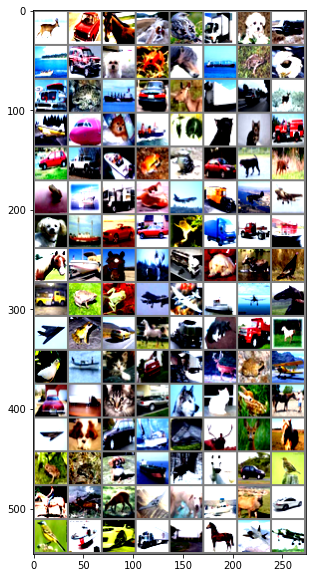

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy() 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# # get some random training images
dataiter = iter(trainloader)
images, labels =  dataiter.next()
print(images.numpy().shape)  

plt.figure(figsize=(20,10))
# show images
imshow(torchvision.utils.make_grid(images))

##  ------------------------------Getting Resnet18 network from model file----------------------- 

1. Get the model
2. print summary
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [16]:
# load to device and print model summary
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
# call now Resnet18 model
model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

##------------------------------Calling training and testing  -------------------------

In [22]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import torch.nn as nn
import torch.nn.functional as F

criterion = nn.CrossEntropyLoss()
model =  ResNet18().to(device)
# without weight reached 80%
# with weight = 0 reached 79%
#with weight = 0.5 reached  Test accuracy = 10%
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.7 )

scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

EPOCHS = 25
for epoch in range(EPOCHS):
    #print("EPOCH:", epoch)
    print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))
    train(model, device, trainloader, optimizer, epoch,criterion)
    scheduler.step()
    test(model, device, testloader)

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch-0 lr: 0.1


Loss=1.1884424686431885 Batch_id=390 Accuracy=44.37: 100%|██████████| 391/391 [01:04<00:00,  6.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 5745/10000 (57.45%)

Epoch-1 lr: 0.1


Loss=0.7799599170684814 Batch_id=390 Accuracy=65.06: 100%|██████████| 391/391 [01:03<00:00,  6.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 7033/10000 (70.33%)

Epoch-2 lr: 0.1


Loss=0.7343652844429016 Batch_id=390 Accuracy=74.94: 100%|██████████| 391/391 [01:03<00:00,  6.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 7394/10000 (73.94%)

Epoch-3 lr: 0.1


Loss=0.717064619064331 Batch_id=390 Accuracy=80.20: 100%|██████████| 391/391 [01:04<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 7904/10000 (79.04%)

Epoch-4 lr: 0.1


Loss=0.41566261649131775 Batch_id=390 Accuracy=83.60: 100%|██████████| 391/391 [01:03<00:00,  6.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 7982/10000 (79.82%)

Epoch-5 lr: 0.1


Loss=0.42034515738487244 Batch_id=390 Accuracy=86.42: 100%|██████████| 391/391 [01:04<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 8053/10000 (80.53%)

Epoch-6 lr: 0.1


Loss=0.3303348422050476 Batch_id=390 Accuracy=88.35: 100%|██████████| 391/391 [01:03<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 8143/10000 (81.43%)

Epoch-7 lr: 0.1


Loss=0.2757072448730469 Batch_id=390 Accuracy=90.26: 100%|██████████| 391/391 [01:03<00:00,  6.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 8297/10000 (82.97%)

Epoch-8 lr: 0.1


Loss=0.25044572353363037 Batch_id=390 Accuracy=91.58: 100%|██████████| 391/391 [01:03<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 8385/10000 (83.85%)

Epoch-9 lr: 0.1


Loss=0.32099437713623047 Batch_id=390 Accuracy=92.90: 100%|██████████| 391/391 [01:03<00:00,  6.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 8319/10000 (83.19%)

Epoch-10 lr: 0.010000000000000002


Loss=0.183114692568779 Batch_id=390 Accuracy=96.86: 100%|██████████| 391/391 [01:03<00:00,  6.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 8723/10000 (87.23%)

Epoch-11 lr: 0.010000000000000002


Loss=0.03650583699345589 Batch_id=390 Accuracy=97.93: 100%|██████████| 391/391 [01:03<00:00,  6.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 8767/10000 (87.67%)

Epoch-12 lr: 0.010000000000000002


Loss=0.027185920625925064 Batch_id=390 Accuracy=98.47: 100%|██████████| 391/391 [01:03<00:00,  6.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 8755/10000 (87.55%)

Epoch-13 lr: 0.010000000000000002


Loss=0.024561643600463867 Batch_id=390 Accuracy=98.92: 100%|██████████| 391/391 [01:04<00:00,  6.10it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 8756/10000 (87.56%)

Epoch-14 lr: 0.010000000000000002


Loss=0.00714173773303628 Batch_id=390 Accuracy=99.19: 100%|██████████| 391/391 [01:03<00:00,  6.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 8762/10000 (87.62%)

Epoch-15 lr: 0.010000000000000002


Loss=0.02018788270652294 Batch_id=390 Accuracy=99.36: 100%|██████████| 391/391 [01:03<00:00,  6.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 8744/10000 (87.44%)

Epoch-16 lr: 0.010000000000000002


Loss=0.012407717294991016 Batch_id=390 Accuracy=99.52: 100%|██████████| 391/391 [01:03<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 8754/10000 (87.54%)

Epoch-17 lr: 0.010000000000000002


Loss=0.023140612989664078 Batch_id=390 Accuracy=99.69: 100%|██████████| 391/391 [01:04<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 8747/10000 (87.47%)

Epoch-18 lr: 0.010000000000000002


Loss=0.010305375792086124 Batch_id=390 Accuracy=99.77: 100%|██████████| 391/391 [01:03<00:00,  6.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 8758/10000 (87.58%)

Epoch-19 lr: 0.010000000000000002


Loss=0.008073592558503151 Batch_id=390 Accuracy=99.84: 100%|██████████| 391/391 [01:03<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 8758/10000 (87.58%)

Epoch-20 lr: 0.0010000000000000002


Loss=0.0038670524954795837 Batch_id=390 Accuracy=99.89: 100%|██████████| 391/391 [01:03<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 8770/10000 (87.70%)

Epoch-21 lr: 0.0010000000000000002


Loss=0.01165400817990303 Batch_id=390 Accuracy=99.90: 100%|██████████| 391/391 [01:03<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 8764/10000 (87.64%)

Epoch-22 lr: 0.0010000000000000002


Loss=0.011785050854086876 Batch_id=390 Accuracy=99.87: 100%|██████████| 391/391 [01:03<00:00,  6.12it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 8755/10000 (87.55%)

Epoch-23 lr: 0.0010000000000000002


Loss=0.0015808420721441507 Batch_id=390 Accuracy=99.93: 100%|██████████| 391/391 [01:04<00:00,  6.11it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Accuracy: 8771/10000 (87.71%)

Epoch-24 lr: 0.0010000000000000002


Loss=0.014468289911746979 Batch_id=390 Accuracy=99.92: 100%|██████████| 391/391 [01:04<00:00,  6.09it/s]



Test set: Accuracy: 8765/10000 (87.65%)



5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship plane


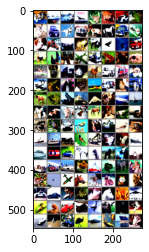

In [23]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

imagesToshow = images.detach().cpu()
# print images
imshow(torchvision.utils.make_grid(imagesToshow))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [24]:
def classwiseAccuracy(model,device,testloader, batchSize,numClasses):
  class_correct = list(0. for i in range(numClasses))
  class_total = list(0. for i in range(numClasses))
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)
          c = (predicted == labels).squeeze()
          for i in range(batchSize):
              label = labels[i]
              class_correct[label] += c[i].item()
              class_total[label] += 1
  for i in range(numClasses):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))


In [25]:
classwiseAccuracy(model, device, testloader,4,10)

Accuracy of plane : 86 %
Accuracy of   car : 96 %
Accuracy of  bird : 81 %
Accuracy of   cat : 76 %
Accuracy of  deer : 96 %
Accuracy of   dog : 87 %
Accuracy of  frog : 88 %
Accuracy of horse : 92 %
Accuracy of  ship : 96 %
Accuracy of truck : 94 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

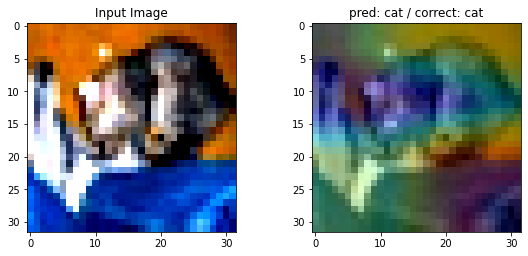

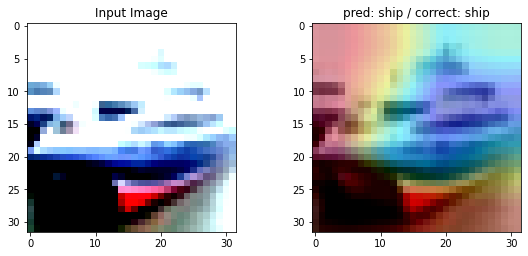

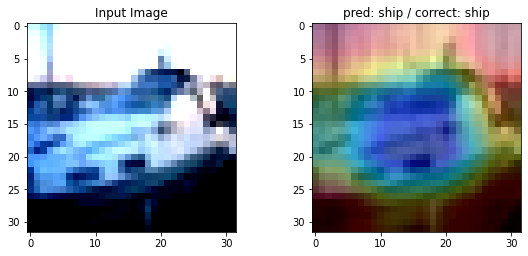

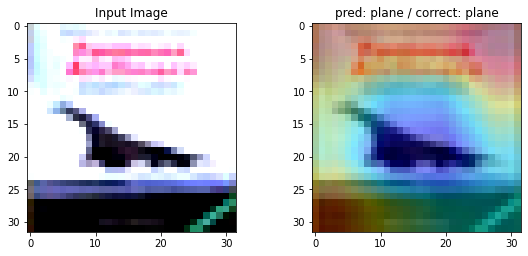

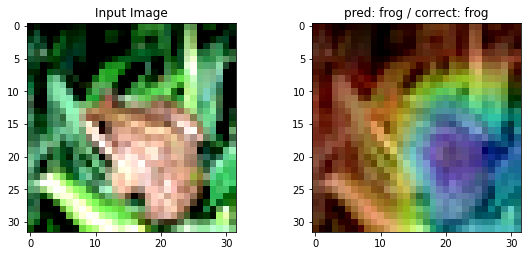

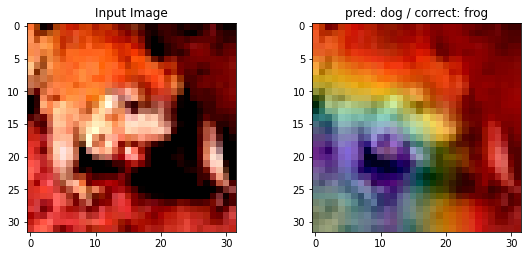

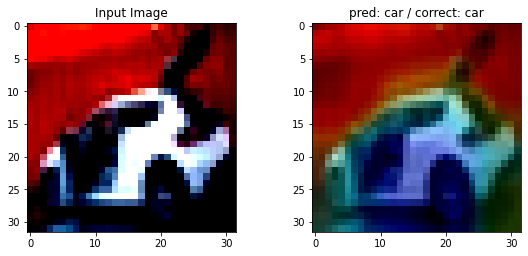

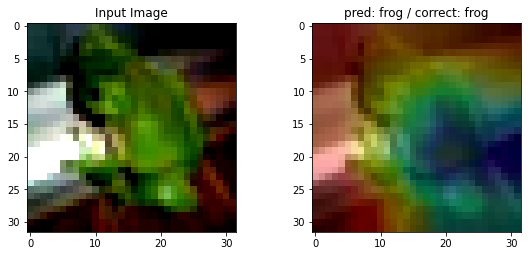

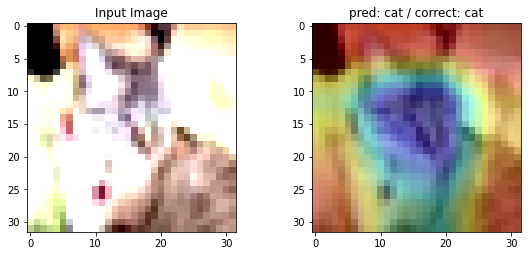

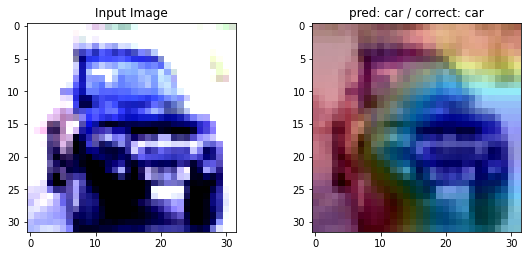

In [26]:
#from gradcam import GradCam
img_tensor_batch, labels = next(iter(testloader))
for idx in range(10):
  gm = GradCam(model=model, img_tensor=img_tensor_batch[idx],
              correct_class=labels[idx], classes=classes,
              feature_module=model.layer4, target_layer_names=['1'])
  gm.visualize()